<a href="https://www.kaggle.com/code/yoansadel/group3?scriptVersionId=219280646" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

>Many diseases such as cancer, tumors, and pneumonia are detected using computer-aided diagnosis with the help of AI models.
This project focuses on disease prediction using a Brain Tumors Images dataset.
It consists of two types of labbeled categories:
>1. **Meningioma (Menin)**
>2. **Glioma**

# Importing Libraries and Defining Functions

In [1]:
!pip install split-folders

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import splitfolders
from imutils import paths
import shutil
import random
import cv2
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
import splitfolders
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [78]:
#copy data from input to output folder and overwrite exiting files
def copy_data(input_folder, output_folder, overwrite=False):
    """
    Args:
        input_folder (str): The path to the input folder.
        output_folder (str): The path to the output folder.
        overwrite (bool, optional): Whether to overwrite existing files. i set it False by defalt.
    """
    logging.basicConfig(filename='copy_data.log', level=logging.INFO)

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        source_path = os.path.join(input_folder, filename)
        destination_path = os.path.join(output_folder, filename)

        if os.path.isfile(source_path):
            if os.path.exists(destination_path) and not overwrite:
                logging.warning(f"Skipping existing file: {destination_path}")
                continue
            try:
                shutil.copy2(source_path, destination_path)
            except Exception as e:
                logging.error(f"Error copying file: {source_path} - {e}")
        elif os.path.isdir(source_path):
            try:
                shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
            except Exception as e:
                logging.error(f"Error copying directory: {source_path} - {e}")

In [90]:
#Extracts class names and their counts from a list of image paths.
def extract_classes_and_counts(imgPaths):
  """
  Args:
    imgPaths: A list of image paths.
  Returns:
  tuple: containing A list of class names and dictionary with class names and thier counts .
  """
  classes = []
  class_counts = {}

  for imgPath in imgPaths:
    className = imgPath.split('/')[-2]
    if className not in classes:
      classes.append(className)
    class_counts[className] = class_counts.get(className, 0) + 1

  return classes, class_counts

In [119]:
#Display random samples of images from generator
def show_images(generator, classes, num_images=25):
    """
    Args:
        generator: The data generator to use for loading images.
        classes: A list of class names for labeling the images.
        num_images (int, optional): Number of images to display (I made default edual 25 but you can change it).
    """

    #Define a list contains all image paths and get them from the generator's directory
    image_paths = list(paths.list_images(generator.directory))

    #Get random images path depend on number you want to see
    num_images = min(num_images, len(image_paths))
    random_image_paths = random.sample(image_paths, num_images)

    #Display images
    plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(random_image_paths):
        plt.subplot(5, 5, i + 1)  #Adjust subplot layout as needed

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Convert images to RGB
        img = cv2.resize(img, generator.target_size)
        plt.imshow(img / 255.0)  # Rescale if needed

        #Get class name from the file path
        class_name = os.path.basename(os.path.dirname(image_path))
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')

    plt.show()

In [79]:
#Trains the model for one epoch and return accuracy and loss.
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Args:
        model: your model to train.
        train_loader: DataLoader for the training data.
        criterion: loss function.
        optimizer: optimizer to use.
        device: The device to train on (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: containing training loss and accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    return train_loss, train_accuracy

In [80]:
#Evaluates the model's performance for one epoch on validation dataset and return val_accuracy and val_loss.
def validate_epoch(model, val_loader, criterion, device):
    """
    Args:
        model: your model to train.
        val_loader: DataLoader for the validation data.
        criterion: loss function.
        device: The device to run the evaluation on (e.g., 'cuda' or 'cpu').
    Returns:
        tuple: containing validation loss and accuracy for the epoch.
    """
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_samples * 100
    return val_loss, val_accuracy

In [81]:
#Plots the training and validation loss and accuracy of the model.

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Args:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        train_accuracies (list): List of training accuracies.
        val_accuracies (list): List of validation accuracies.
    """

    plt.figure(figsize=(12, 5))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="red", linestyle="-", marker="o")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="green", linestyle="-", marker="o")
    plt.title("Train vs Validation Loss", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color="red", linestyle="-", marker="o")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color="green", linestyle="-", marker="o")
    plt.title("Train vs Validation Accuracy", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [185]:
#Plots a confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [190]:
#Displays random samples of images with their true and predicted labels.
def show_images_with_predictions(images, true_labels, predicted_labels, classes, num_images=25):
    """
    Args:
        images (list or NumPy array): images to display.
        true_labels (list or NumPy array): true labels for the images.
        predicted_labels (list or NumPy array): predicted labels for the images.
        classes (list): List of class names.
        num_images (int, optional): Number of images to display (I made default edual 25 but you can change it).
    """

    num_images = min(num_images, len(images))
    random_indices = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(20, 20))
    for i, index in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)  # Adjust subplot layout as needed

        img = images[index]
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()  #Convert to NumPy if needed
        img = img.astype(np.uint8)  #Ensure data type is uint8 for display

        #Convert images to RGB
        if img.shape[0] == 3:  #Channels-first format
            img = img.transpose(1, 2, 0)
        elif img.shape[-1] != 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        plt.imshow(img)

        true_label = classes[true_labels[index]]
        predicted_label = classes[predicted_labels[index]]

        #Display title with true and predicted labels
        title = f"True: {true_label},\nPredicted: {predicted_label}"
        title_color = "blue" if true_label == predicted_label else "red"  #Make incorrect predictions in red
        plt.title(title, color=title_color, fontsize=12)

        plt.axis('off')

    plt.show()

# Data Preprocessing and Visualization

In [3]:
#unmount
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [195]:
from google.colab import drive
drive.mount('/content/GoogleDrive')

Mounted at /content/GoogleDrive


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
input= '/content/GoogleDrive/MyDrive/Group3/test'
output= '/content/GoogleDrive/MyDrive/Group3/output'
copy_data(input, output)

In [8]:
imgPaths = list(paths.list_images(output))
if imgPaths:
    print(imgPaths[0].split('/'))
else:
    print("No images found.")

['', 'content', 'GoogleDrive', 'MyDrive', 'Group3', 'output', 'brain_menin', 'brain_menin_0186.jpg']


In [199]:
#Dataset before balancing
classes, class_counts = extract_classes_and_counts(imgPaths)
# Print the results
print("Classes:", classes)
print("Class Counts:", class_counts)

Classes: ['brain_glioma', 'brain_menin']
Class Counts: {'brain_glioma': 1000, 'brain_menin': 47}


In [9]:
#shuffle the images order
random.shuffle(imgPaths)

## Data Augmentation

In [49]:
# Data Augmentation for 'brain_menin' class
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

menin_dir = '/content/GoogleDrive/MyDrive/Group3/output/brain_menin'
#menin_image_paths = list(paths.list_images(menin_dir))
augmented_dir = '/content/augmen_brain_menin'

os.makedirs(augmented_dir, exist_ok=True)

target_count = brain_glioma_count
#augment_count = max(0, target_count)

# Augmentation
i = 1
for img_path in paths.list_images(menin_dir):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        continue

    img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator

    for batch in datagen.flow(
        img,
        batch_size=1,
        save_to_dir=augmented_dir,
        save_prefix='brain_menin',
        save_format='jpg'
    ):
        i += 1
        if i >= target_count:
            break
    if i >= target_count:
        break

print(f"Augmented {i} images. Saved temporarily to: {augmented_dir}")


Augmented 1000 images. Saved temporarily to: /content/augmen_brain_menin


In [197]:
#Combine augmented images and original images into single folder and add it to the dataset
combined_dir = '/content/GoogleDrive/MyDrive/Group3/final_data/brain_menin'
os.makedirs(combined_dir, exist_ok=True)

copy_data(menin_dir, combined_dir)
copy_data(augmented_dir, combined_dir)


In [198]:
#Add brain glioma to the dataset
source_folder = '/content/GoogleDrive/MyDrive/Group3/output/brain_glioma'
destination_folder = '/content/GoogleDrive/MyDrive/Group3/final_data/brain_glioma'

copy_data(source_folder, destination_folder)

In [89]:
#paths
brain_glioma = '/content/GoogleDrive/MyDrive/Group3/final_data/brain_glioma'
brain_menin = '/content/GoogleDrive/MyDrive/Group3/final_data/brain_menin'

all_image_paths = []
for folder_path in [brain_glioma, brain_menin]:
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # if needed we will Adjust file extensions
            all_image_paths.append(os.path.join(folder_path, filename))
classes, class_counts = extract_classes_and_counts(all_image_paths)
print("Classes:", classes)
print("Class Counts:", class_counts)

Classes: ['brain_glioma', 'brain_menin']
Class Counts: {'brain_glioma': 1000, 'brain_menin': 1004}


## Splitting the data

In [196]:
input_folder = '/content/GoogleDrive/MyDrive/Group3/final_data'
output_folder = '/content/GoogleDrive/MyDrive/Group3/split_data'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .1, .2))  # ratio of train, val, test

Copying files: 2004 files [00:49, 40.38 files/s]


In [ ]:
# Get a list of all subdirectories inside the input folder
#subfolders = [os.path.join(input_folder, folder) for folder in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, folder))]

# Loop through each subfolder and split
#for folder in subfolders:
#    print(f"Processing folder: {folder}")
#    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .1, .2))  # ratio of train, val, test


In [65]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
IMGSIZE = (128,128)
img_names = []


#classes = sorted(os.listdir(os.path.join(output_folder, 'train')))
#classes = ['brain_glioma', 'brain_menin']

# Prepare image paths for processing
for root, dirs, files in os.walk(output_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            imgPath = os.path.join(root, file)
            trainOrTestOrVal = imgPath.split('/')[-3]  # train/test/val
            className = imgPath.split('/')[-2]  # the class

            # Read and resize image
            img = cv2.imread(imgPath)
            img = cv2.resize(img,IMGSIZE)

            # Append to appropriate dataset
            if trainOrTestOrVal == 'train':
                X_train.append(img)
                y_train.append(classes.index(className))
                img_names.append(file)
            elif trainOrTestOrVal == 'test':
                X_test.append(img)
                y_test.append(classes.index(className))
            elif trainOrTestOrVal == 'val':
                X_val.append(img)
                y_val.append(classes.index(className))

# Print the number of images in each set
print(f"Training set: {len(X_train)} images, {len(y_train)} labels")
print(f"Testing set: {len(X_test)} images, {len(y_test)} labels")
print(f"Validation set: {len(X_val)} images, {len(y_val)} labels")

Training set: 1402 images, 1402 labels
Testing set: 402 images, 402 labels
Validation set: 200 images, 200 labels


In [66]:
df = pd.DataFrame({
    'File Name': img_names,
    'Category': y_train
})
print(df.head())


                File Name  Category
0  brain_menin_0_6312.jpg         1
1   brain_menin_0_813.jpg         1
2  brain_menin_0_4966.jpg         1
3  brain_menin_0_1088.jpg         1
4  brain_menin_0_6523.jpg         1


In [67]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

## Data Visualization

In [104]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_path = '/content/GoogleDrive/MyDrive/Group3/split_data/train'
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

Found 1402 images belonging to 2 classes.


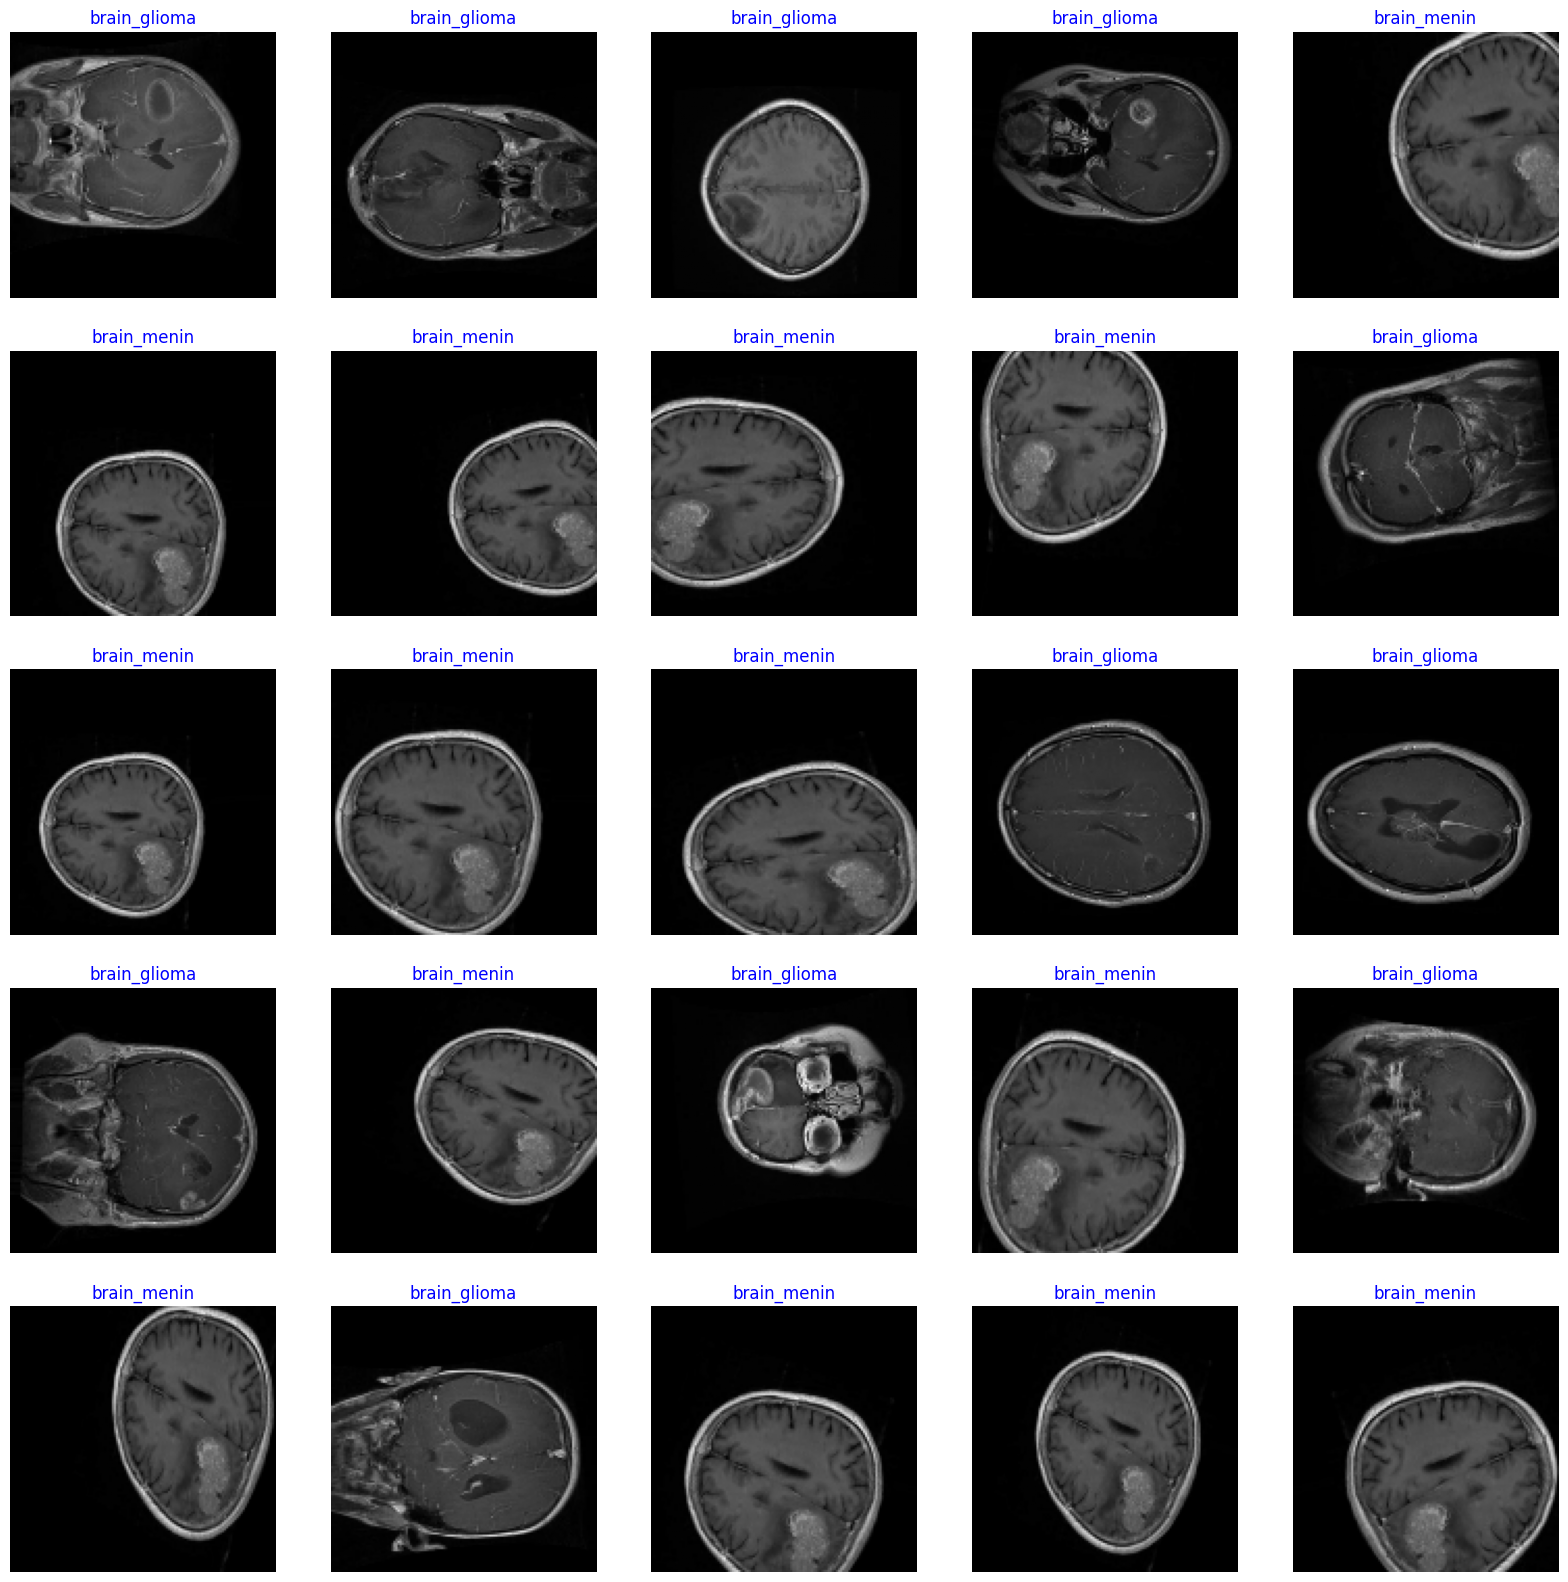

In [101]:
show_images(train_generator, classes)

# Converting to Tensor

In [110]:
x_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
x_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Model 1: ResNet


## Build ResNet Model

In [140]:
#INPUT_SHAPE = (3, 512, 512)
#NUM_CLASSES = 2
#BATCH_SIZE = 32
LEARNING_RATE = 0.0001

In [115]:
base_model = models.resnet50(pretrained=True)
base_model.fc = nn.Linear(base_model.fc.in_features, 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = base_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=LEARNING_RATE)

## Train and save ResNet Model

In [147]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50

In [118]:
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(resnet_model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_epoch(resnet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/50, Train Loss: 0.4414, Train Accuracy: 89.73%, Validation Loss: 0.2964, Validation Accuracy: 96.00%
Epoch 2/50, Train Loss: 0.2442, Train Accuracy: 96.50%, Validation Loss: 0.2091, Validation Accuracy: 96.50%
Epoch 3/50, Train Loss: 0.1760, Train Accuracy: 97.00%, Validation Loss: 0.1687, Validation Accuracy: 96.00%
Epoch 4/50, Train Loss: 0.1560, Train Accuracy: 97.08%, Validation Loss: 0.1559, Validation Accuracy: 95.50%
Epoch 5/50, Train Loss: 0.1331, Train Accuracy: 97.29%, Validation Loss: 0.1335, Validation Accuracy: 96.00%
Epoch 6/50, Train Loss: 0.1197, Train Accuracy: 97.08%, Validation Loss: 0.1273, Validation Accuracy: 96.00%
Epoch 7/50, Train Loss: 0.1149, Train Accuracy: 97.15%, Validation Loss: 0.1254, Validation Accuracy: 96.00%
Epoch 8/50, Train Loss: 0.1121, Train Accuracy: 97.15%, Validation Loss: 0.1195, Validation Accuracy: 96.00%
Epoch 9/50, Train Loss: 0.0976, Train Accuracy: 96.93%, Validation Loss: 0.1155, Validation Accuracy: 96.00%
Epoch 10/50, Train 

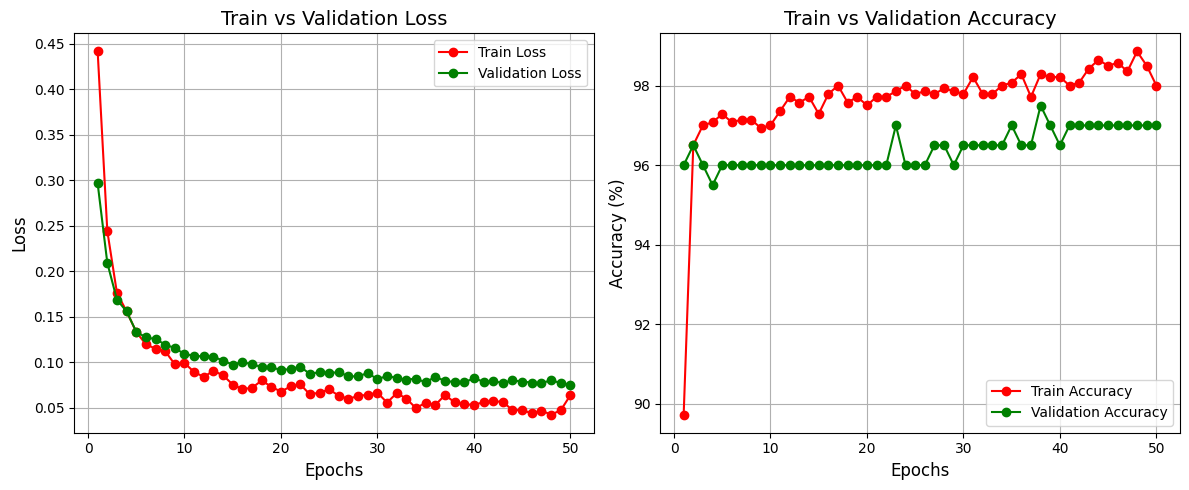

In [120]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [122]:
torch.save(resnet_model.state_dict(), '/content/GoogleDrive/MyDrive/Group3/models/resnet_model.pth')

# Model 2: MobileNet


## Build MobileNet Model

In [200]:
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.last_channel, 2)

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model = mobilenet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.0001)

In [150]:
summary(mobilenet_model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

## Train and save MobileNet Model

In [151]:
mobile_train_losses = []
mobile_val_losses = []
mobile_train_accuracies = []
mobile_val_accuracies = []

In [154]:
num_epochs = 50
best_val_loss = float('inf')
patience = 3  #Stop if there is no sign of improvements for 3 epochs
epochs_without_improvement = 0

In [155]:
for epoch in range(num_epochs):

    train_loss, train_accuracy = train_epoch(mobilenet_model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_epoch(mobilenet_model, val_loader, criterion, device)

    mobile_train_losses.append(train_loss)
    mobile_train_accuracies.append(train_accuracy)
    mobile_val_losses.append(val_loss)
    mobile_val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch 1/50, Train Loss: 0.1098, Train Accuracy: 96.08%, Validation Loss: 0.0339, Validation Accuracy: 99.00%
Epoch 2/50, Train Loss: 0.0163, Train Accuracy: 99.71%, Validation Loss: 0.0290, Validation Accuracy: 99.00%
Epoch 3/50, Train Loss: 0.0034, Train Accuracy: 100.00%, Validation Loss: 0.0266, Validation Accuracy: 99.00%
Epoch 4/50, Train Loss: 0.0027, Train Accuracy: 100.00%, Validation Loss: 0.0428, Validation Accuracy: 99.00%
Epoch 5/50, Train Loss: 0.0020, Train Accuracy: 99.93%, Validation Loss: 0.0138, Validation Accuracy: 99.50%
Epoch 6/50, Train Loss: 0.0066, Train Accuracy: 99.86%, Validation Loss: 0.0349, Validation Accuracy: 98.50%
Epoch 7/50, Train Loss: 0.0019, Train Accuracy: 99.93%, Validation Loss: 0.0198, Validation Accuracy: 99.50%
Epoch 8/50, Train Loss: 0.0018, Train Accuracy: 100.00%, Validation Loss: 0.0303, Validation Accuracy: 98.50%
Early stopping at epoch 8


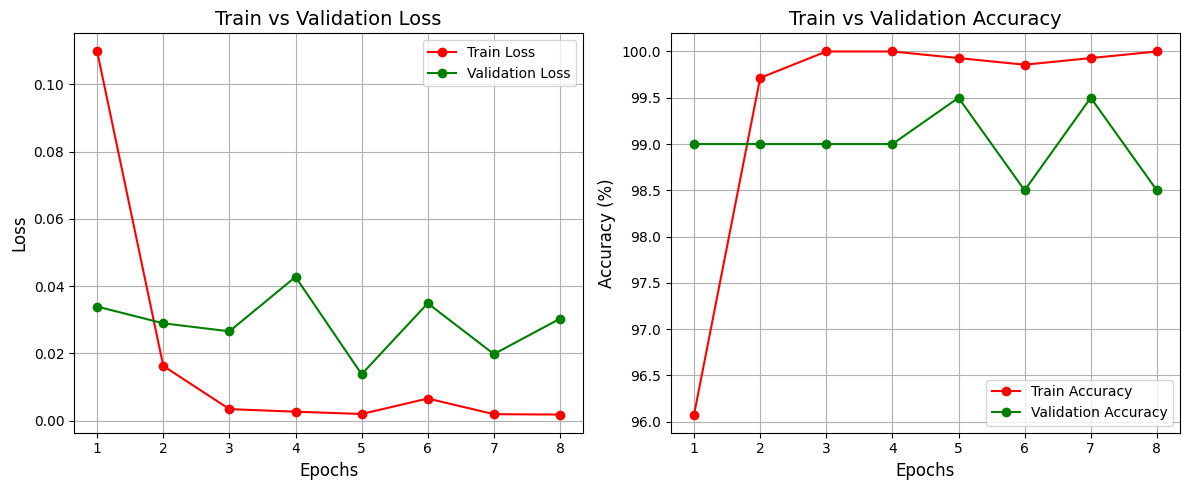

In [156]:
plot_training_history(mobile_train_losses, mobile_val_losses, mobile_train_accuracies, mobile_val_accuracies)

In [157]:
torch.save(mobilenet_model.state_dict(), '/content/GoogleDrive/MyDrive/Group3/models/mobilenet_model.pth')

# Evaluation and Results

## Import and Load Models

In [201]:
from google.colab import drive
drive.mount('/content/GoogleDrive')

Drive already mounted at /content/GoogleDrive; to attempt to forcibly remount, call drive.mount("/content/GoogleDrive", force_remount=True).


In [202]:
   #Create the ResNet model instance with
   base_model = models.resnet50(pretrained=True)
   base_model.fc = nn.Linear(base_model.fc.in_features, 2)
   resnet_model = base_model.to(device)  #Move to device (GPU or CPU)

   #Create the MobileNet model instance
   mobilenet_model = models.mobilenet_v2(pretrained=True)
   mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.last_channel, 2)
   mobilenet_model = mobilenet_model.to(device) # Move to device (GPU or CPU)

In [204]:
#Load resnet_model
resnet_model.load_state_dict(torch.load('/content/GoogleDrive/MyDrive/Group3/models/resnet_model.pth'))
#Load mobilenet_model
mobilenet_model.load_state_dict(torch.load('/content/GoogleDrive/MyDrive/Group3/models/mobilenet_model.pth'))

<All keys matched successfully>

In [205]:
#Evaluation mode
resnet_model.eval()
mobilenet_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Evaluating MobileNet and ResNet


In [164]:
#Predictions for ResNet
resnet_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        resnet_predictions.extend(preds.cpu().numpy())

#Predictions for MobileNet
mobilenet_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet_model(inputs)
        _, preds = torch.max(outputs, 1)
        mobilenet_predictions.extend(preds.cpu().numpy())



In [207]:
#Convert predictions and true labels (to be array) for evaluation
resnet_predictions = np.array(resnet_predictions)
mobilenet_predictions = np.array(mobilenet_predictions)
y_test_np = y_test

#Calculate evaluation metrics for ResNet
resnet_accuracy = accuracy_score(y_test_np, resnet_predictions)
resnet_precision = precision_score(y_test_np, resnet_predictions)
resnet_recall = recall_score(y_test_np, resnet_predictions)
resnet_f1 = f1_score(y_test_np, resnet_predictions)

#Calculate evaluation metrics for MobileNet
mobilenet_accuracy = accuracy_score(y_test_np, mobilenet_predictions)
mobilenet_precision = precision_score(y_test_np, mobilenet_predictions)
mobilenet_recall = recall_score(y_test_np, mobilenet_predictions)
mobilenet_f1 = f1_score(y_test_np, mobilenet_predictions)

In [210]:
#Dictionary of metrics
metrics = {
    'Model': ['ResNet', 'MobileNet'],
    'Accuracy': [resnet_accuracy, mobilenet_accuracy],
    'Precision': [resnet_precision, mobilenet_precision],
    'Recall': [resnet_recall, mobilenet_recall],
    'F1-score': [resnet_f1, mobilenet_f1]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

       Model  Accuracy  Precision    Recall  F1-score
0     ResNet  0.980100   0.989899  0.970297  0.980000
1  MobileNet  0.987562   1.000000  0.975248  0.987469


## Visualization

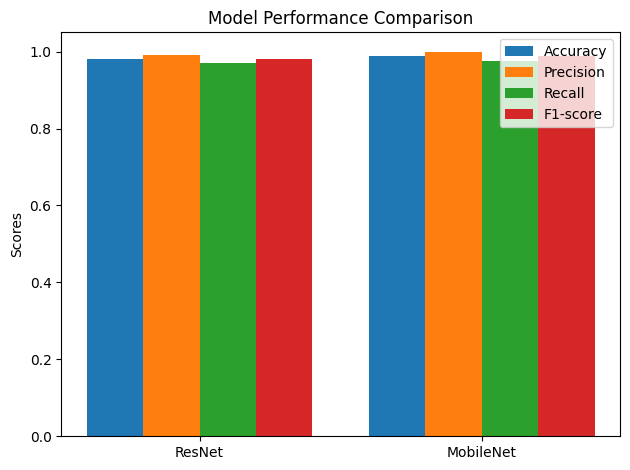

In [168]:
#comparing Using bar chart
models = ['ResNet', 'MobileNet']
accuracy = [resnet_accuracy, mobilenet_accuracy]
precision = [resnet_precision, mobilenet_precision]
recall = [resnet_recall, mobilenet_recall]
f1_score = [resnet_f1, mobilenet_f1]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision, width, label='Precision')
rects3 = ax.bar(x + width/2, recall, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()

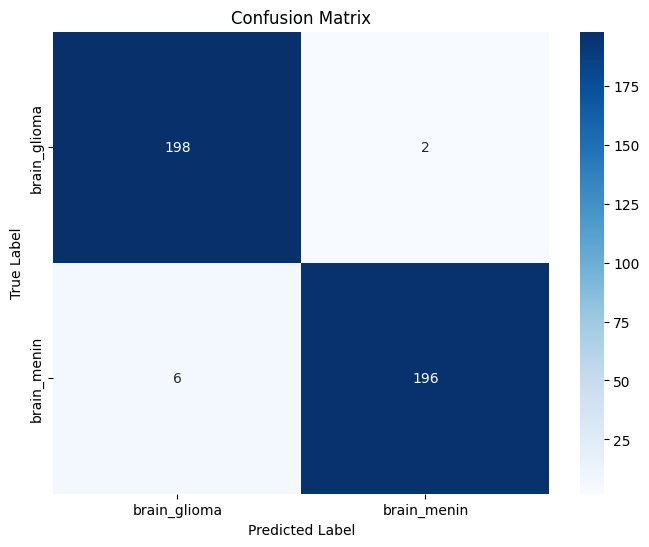

In [188]:
#Create confusion matrix for ResNet
plot_confusion_matrix(y_test, resnet_predictions, classes)

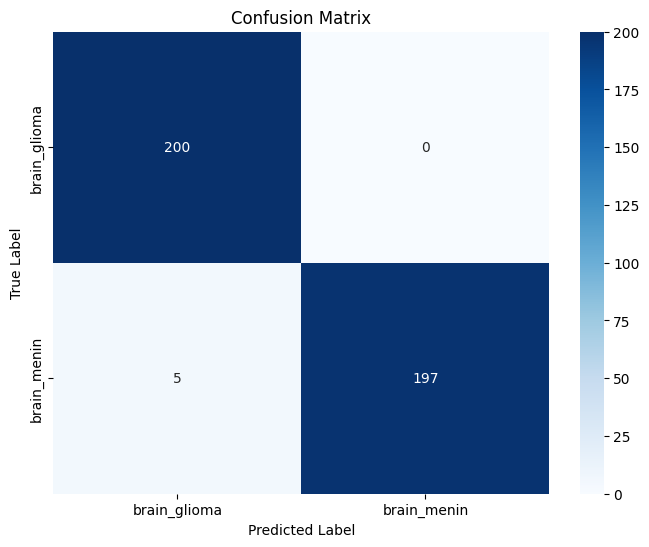

In [189]:
#Create confusion matrix for MobileNet
plot_confusion_matrix(y_test, mobilenet_predictions, classes)

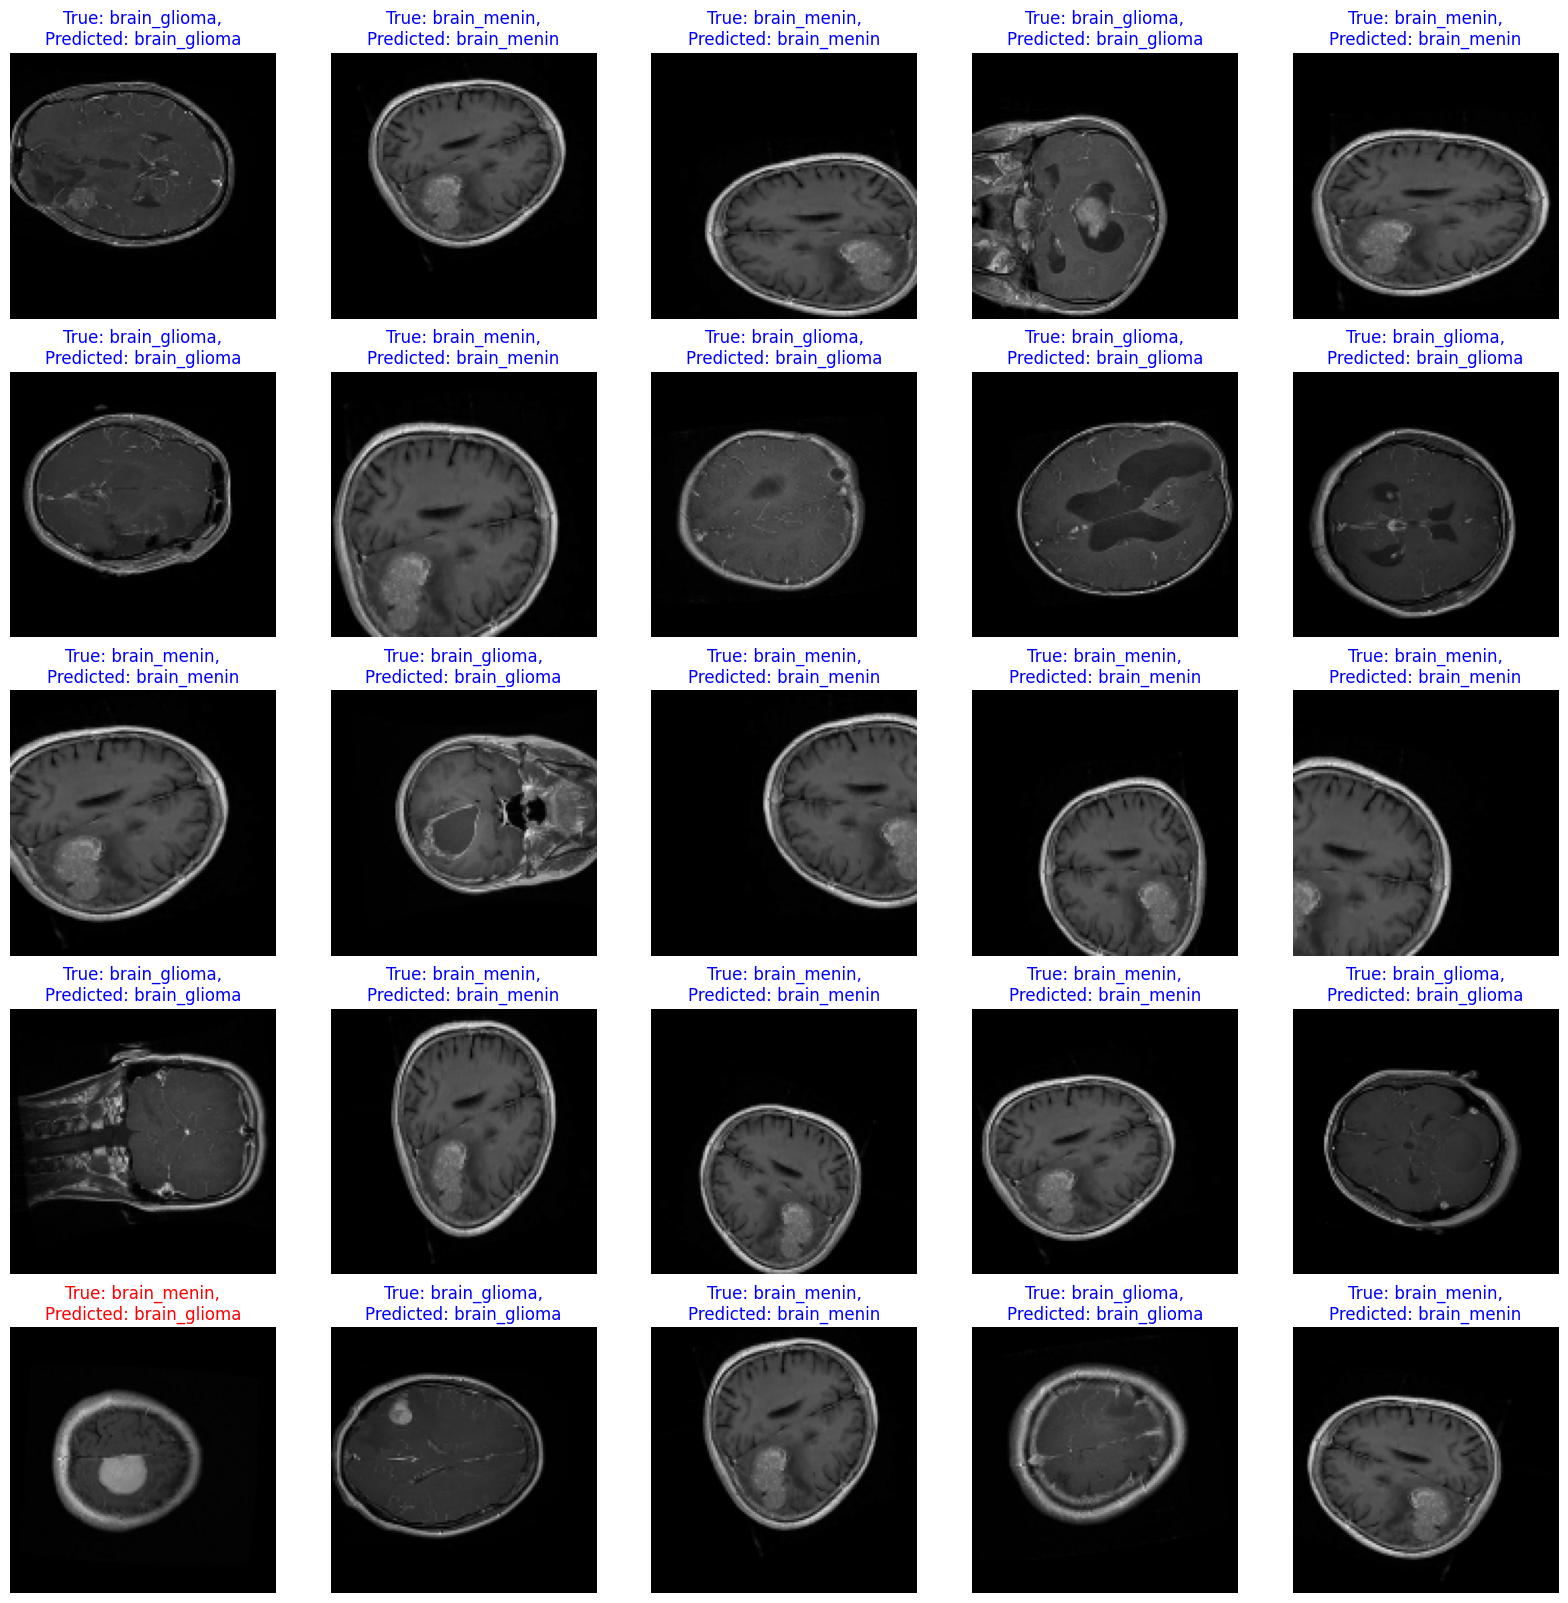

In [182]:
#Display images with ResNet predictions
show_images_with_predictions(X_test, y_test, resnet_predictions, classes, num_images=25)

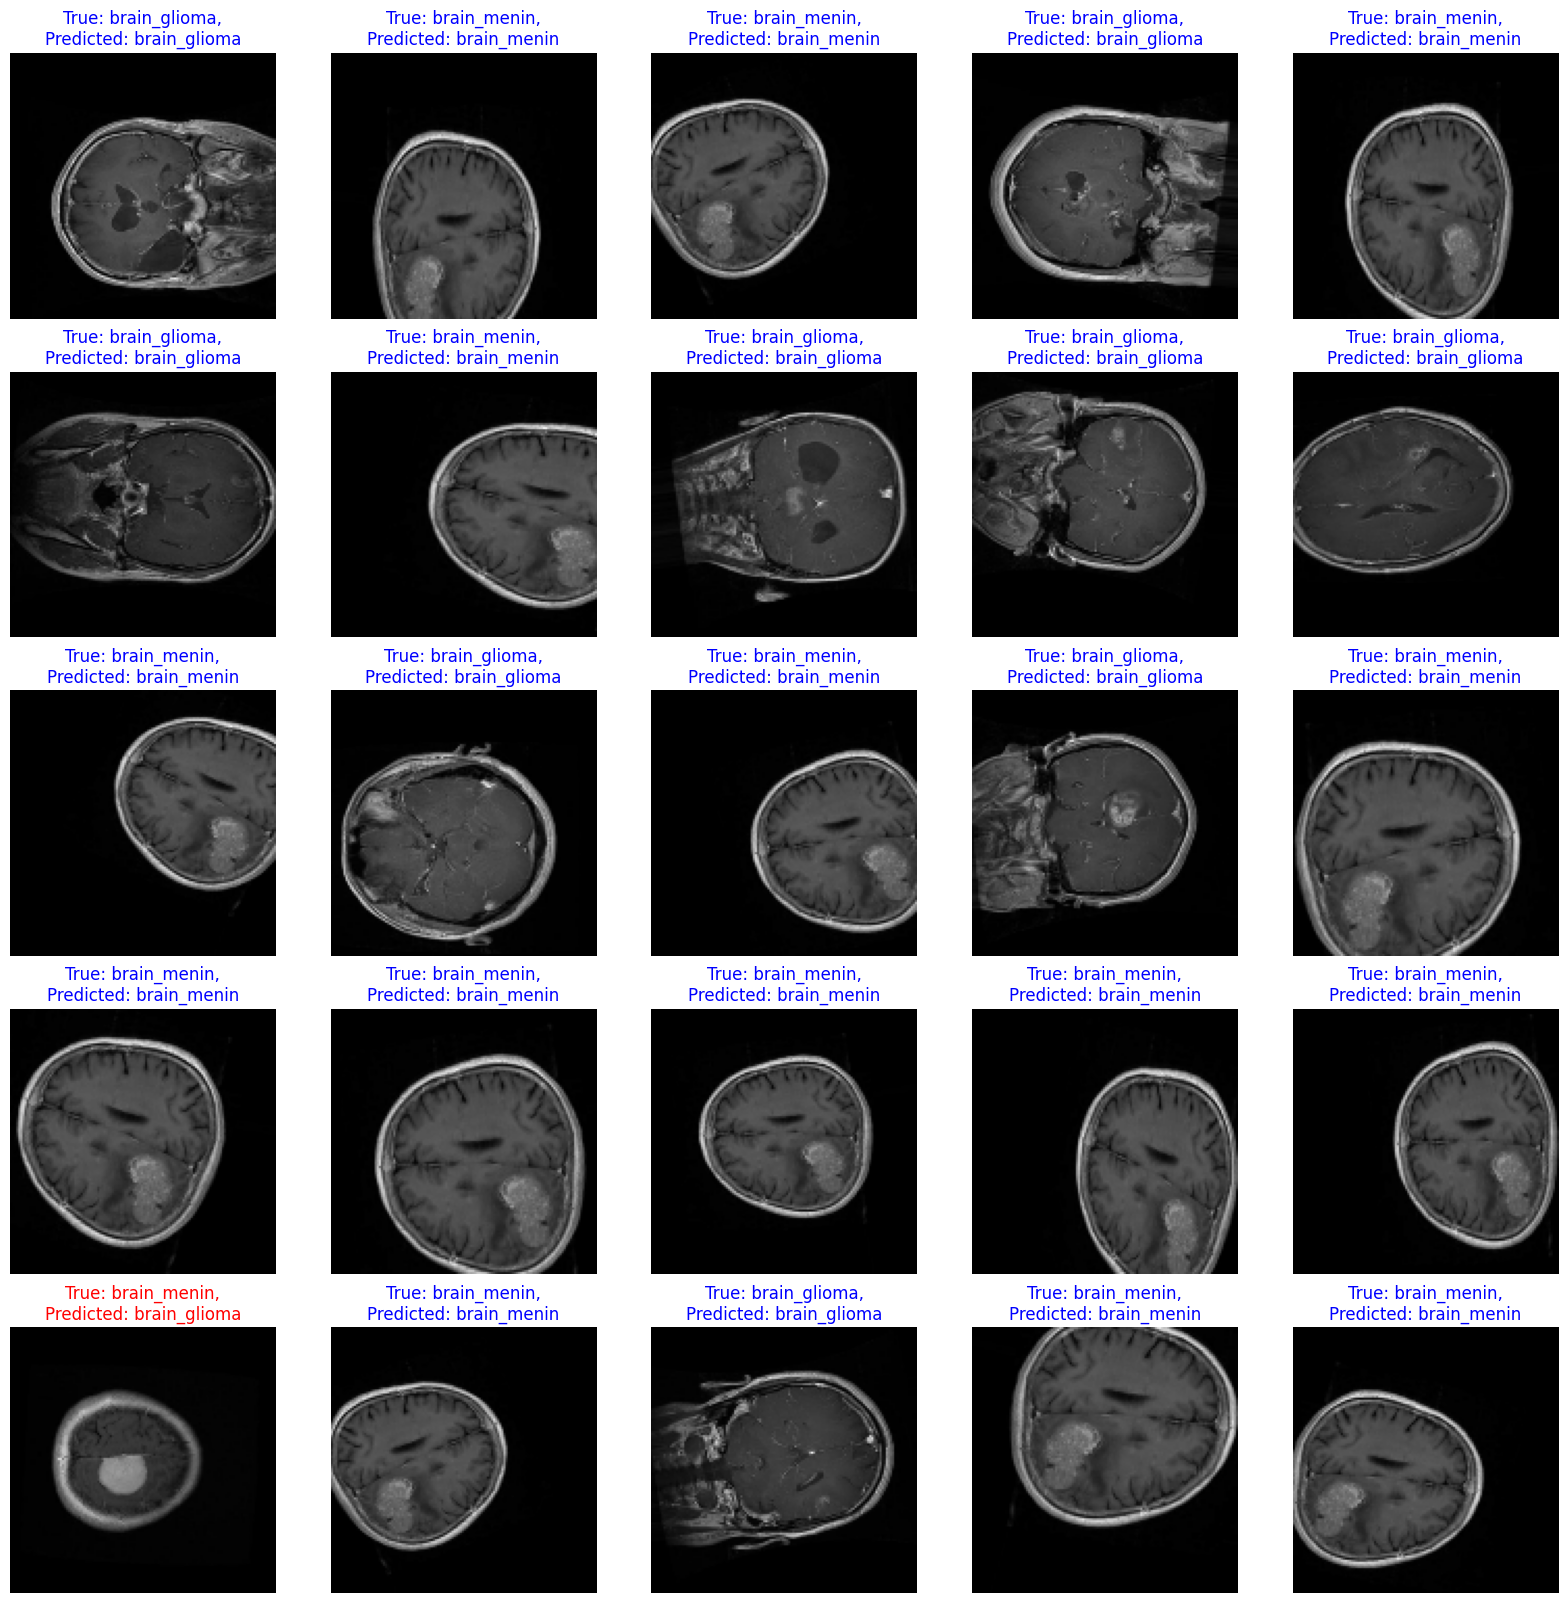

In [180]:
#Display images with MobileNet predictions
show_images_with_predictions(X_test, y_test, mobilenet_predictions, classes, num_images=25)